In [23]:
import time
import os
import subprocess
import cv2
import moviepy
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Recording Video with a webcam

In [24]:
def capture_video(folder_name, delay_s=3, video_duration_s = 5):
    folder_path = f"../data/videos/{folder_name}"
    os.makedirs(folder_path, exist_ok=True)

    print("\nTaking video in...")
    while delay_s > 0:
        print(f"{delay_s}...")
        time.sleep(1)
        delay_s -= 1

    raw_video_path = f"{folder_path}/i420.avi"
    command = f"ffmpeg -y -f v4l2 -framerate 30 -i /dev/video0 -t {video_duration_s} {raw_video_path}"
    subprocess.run(command, shell=True)

    formats = {
        "mp4.mp4": "libx264",   # MP4 format
        "divx.avi": "mpeg4",    # DivX format
        "flv.flv": "flv",       # FLV format
        "xvid.avi": "libxvid"   # Xvid format
    }

    for filename, codec in formats.items():
        output_path = f"{folder_path}/{filename}"
        command = f"ffmpeg -i {raw_video_path} -c:v {codec} {output_path}"
        subprocess.run(command, shell=True)


In [25]:
capture_video("test_1")
capture_video("test_2")


Taking video in...
3...
2...
1...


ffmpeg version n7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 14.2.1 (GCC) 20240910
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-frei0r --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libdav1d --enable-libdrm --enable-libdvdnav --enable-libdvdread --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgsm --enable-libharfbuzz --enable-libiec61883 --enable-libjack --enable-libjxl --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libplacebo --enable-libpulse --enable-librav1e --enable-librsvg --enable-librubberband --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable


Taking video in...
3...
2...
1...


ffmpeg version n7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 14.2.1 (GCC) 20240910
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-frei0r --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libdav1d --enable-libdrm --enable-libdvdnav --enable-libdvdread --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgsm --enable-libharfbuzz --enable-libiec61883 --enable-libjack --enable-libjxl --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libplacebo --enable-libpulse --enable-librav1e --enable-librsvg --enable-librubberband --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable

# Pricessing videos into DF

In [26]:
def get_df_video_info(duration = 5, fps=30):
    base_path = "../data/videos/"
    test_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    
    data = []

    for folder_name in test_folders:
        folder_path = os.path.join(base_path, folder_name)
        
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)

            if file_path[-4:] == ".jpg":
                continue

            cap = cv2.VideoCapture(file_path)
            cap.set(cv2.CAP_PROP_POS_FRAMES, 1)
            _, frame= cap.read()
            cv2.imwrite(f"{folder_path}/reference.ppm", frame)
            ref_img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

            cap = cv2.VideoCapture(file_path)
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(duration*fps/3))
            _, frame= cap.read()
            cv2.imwrite(f"{folder_path}/output.jpg", frame)
            compare_img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
            
            if compare_img is not None:
                # Resize to match reference if needed
                compare_img = cv2.resize(compare_img, (ref_img.shape[1], ref_img.shape[0]))

                # Compute SSIM
                ssim_score = ssim(ref_img, compare_img)
                
                # Compute Mean Squared Error (MSE)
                mse_score = np.mean((ref_img.astype("float") - compare_img.astype("float")) ** 2)

            if os.path.exists(file_path):
                file_size = os.path.getsize(file_path) / 1024
                if ref_img is not None:
                    height, width = ref_img.shape[:2]
                image_size = f"{width}x{height}"  # Known capture resolution
                data.append([folder_name, file, duration, fps, image_size, file_size, ssim_score, mse_score])

    # Create a global DataFrame
    df = pd.DataFrame(data, columns=["test no.", "video format", "duration", "fps", "image size", "file size", "SSIM", "MSE"])
    return df

In [27]:
df = get_df_video_info()
df.head(10)

,test no.,video format,duration,fps,image size,file size,SSIM,MSE
0,test_2,i420.avi,5,30,640x360,165.302734,0.894732,143.811363
1,test_2,mp4.mp4,5,30,640x360,177.708984,0.889751,175.921515
2,test_2,flv.flv,5,30,640x360,181.651367,0.896770,142.712951
3,test_2,xvid.avi,5,30,640x360,109.498047,0.892702,141.948681
4,test_2,divx.avi,5,30,640x360,164.679688,0.895766,142.843398
5,test_1,i420.avi,5,30,640x360,163.863281,0.866027,261.020781
6,test_1,mp4.mp4,5,30,640x360,177.172852,0.876673,257.240859
7,test_1,flv.flv,5,30,640x360,179.808594,0.865700,259.120664
8,test_1,xvid.avi,5,30,640x360,112.408203,0.864958,257.547201
9,test_1,divx.avi,5,30,640x360,161.730469,0.865105,259.611141


In [28]:
def get_df_image_info():
    base_path = "../data/videos/"
    image_formats = ["bmp", "jpg", "png"]
    test_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    
    data = []

    for folder_name in test_folders:
        folder_path = os.path.join(base_path, folder_name)

        ref_img_path = os.path.join(folder_path, "reference.ppm")
        ref_img = cv2.imread(ref_img_path, cv2.IMREAD_GRAYSCALE)
        
        for fmt in image_formats:
            file_path = os.path.join(folder_path, f"output.{fmt}")
            compare_img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if compare_img is not None:
                # Resize to match reference if needed
                compare_img = cv2.resize(compare_img, (ref_img.shape[1], ref_img.shape[0]))

                # Compute SSIM
                ssim_score = ssim(ref_img, compare_img)
                
                # Compute Mean Squared Error (MSE)
                mse_score = np.mean((ref_img.astype("float") - compare_img.astype("float")) ** 2)

            if os.path.exists(file_path):
                file_size = os.path.getsize(file_path) / 1024  # Convert to KB
                img = cv2.imread(file_path)
                if img is not None:
                    height, width = img.shape[:2]
                image_size = f"{width}x{height}"  # Known capture resolution
                data.append([folder_name, fmt.upper(), image_size, f"{file_size:.2f} KB", round(ssim_score, 4), round(mse_score, 4)])

    # Create a global DataFrame
    df = pd.DataFrame(data, columns=["Test Folder", "Format", "Resolution", "File Size", "SSIM", "MSE"])
    return df

df_images = get_df_image_info()
df_images.head(10)

[ WARN:0@9044.789] global loadsave.cpp:268 findDecoder imread_('../data/videos/test_2/output.bmp'): can't open/read file: check file path/integrity
[ WARN:0@9044.858] global loadsave.cpp:268 findDecoder imread_('../data/videos/test_2/output.png'): can't open/read file: check file path/integrity
[ WARN:0@9044.859] global loadsave.cpp:268 findDecoder imread_('../data/videos/test_1/output.bmp'): can't open/read file: check file path/integrity
[ WARN:0@9044.913] global loadsave.cpp:268 findDecoder imread_('../data/videos/test_1/output.png'): can't open/read file: check file path/integrity


,Test Folder,Format,Resolution,File Size,SSIM,MSE
0,test_2,JPG,640x360,28.84 KB,0.8953,143.0419
1,test_1,JPG,640x360,28.76 KB,0.8646,259.7215


# Visualisation

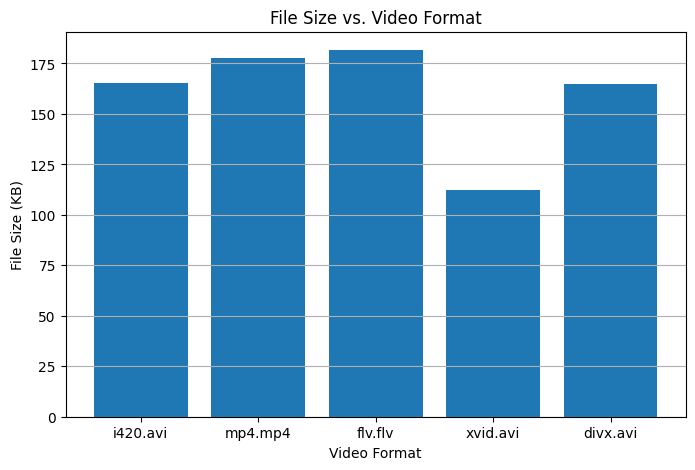

In [32]:
plt.figure(figsize=(8, 5))
plt.bar(df["video format"], df["file size"])
plt.xlabel("Video Format")
plt.ylabel("File Size (KB)")
plt.title("File Size vs. Video Format")
plt.grid(axis="y")
plt.show()

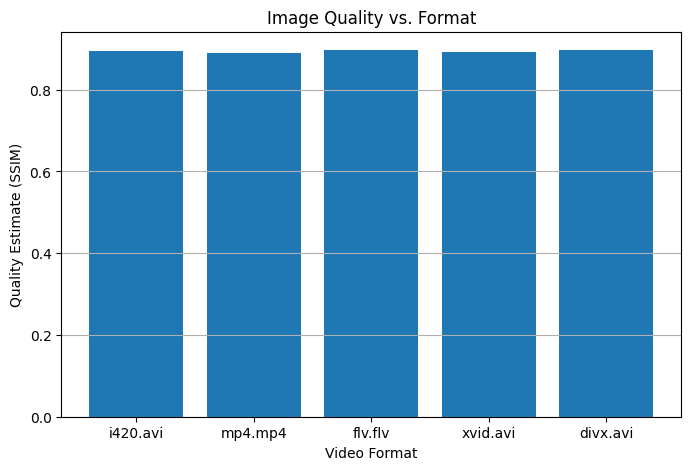

In [33]:
plt.figure(figsize=(8, 5))
plt.bar(df["video format"], df["SSIM"])
plt.xlabel("Video Format")
plt.ylabel("Quality Estimate (SSIM)")
plt.title("Image Quality vs. Format")
plt.grid(axis="y")
plt.show()

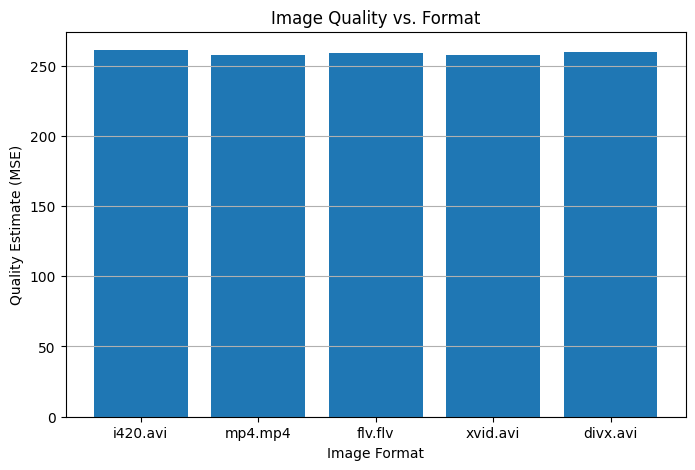

In [35]:
plt.figure(figsize=(8, 5))
plt.bar(df["video format"], df["MSE"])
plt.xlabel("Image Format")
plt.ylabel("Quality Estimate (MSE)")
plt.title("Image Quality vs. Format")
plt.grid(axis="y")
plt.show()